In [1]:
import os 
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, BitsAndBytesConfig, pipeline, logging
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Dataset
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")

In [2]:
dataset="bentrevett/multi30k"
model_id="microsoft/phi-2"
output_model="phi2-multi30k-v4"

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

torch.set_default_device("cuda")

model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", torch_dtype="auto", trust_remote_code=True, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)
# Instruct chat template chat template
#inputs = tokenizer("Instruct: translate the guy with the orange hat is staring at something to german\nOutput:", return_tensors="pt", return_attention_mask=False)

inputs = tokenizer("Instruct: translate English to German.\nInput: the guy with the orange hat is staring at something.\nOutput:", return_tensors="pt", return_attention_mask=False)
outputs = model.generate(**inputs, max_length=200)
text = tokenizer.batch_decode(outputs)[0]
print(text)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Instruct: translate English to German.
Input: the guy with the orange hat is staring at something.
Output: Der Mann mit der orange Haut ist ganz zurückgehend.
<|endoftext|>


In [ ]:
inputs = tokenizer("Instruct: translate English to German.\nInput: the guy with the orange hat is staring at something.\nOutput:", return_tensors="pt", return_attention_mask=False)
outputs = model.generate(**inputs, max_length=200)
text = tokenizer.batch_decode(outputs)[0]
print(text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [4]:
def formatted_prompt(question)-> str:
    return f"Instruct: Translate German to English.\nInput: {question}\nOutput:"

In [5]:
def formatted_train(question, response):
    instruction_key = "Instruct: Translate German to English."
    return f"{instruction_key}\nInput: {question}\nOutput: {response}"

def prepare_train_data_multi_30k(data_id):
    data = load_dataset(data_id, split="train")
    data_df = data.to_pandas()
    data_df["text"] = data_df[["de", "en"]].apply(lambda x: "Instruct: Translate German to English\nInput: " + x['de'] + "\nOutput: " + x['en'], axis=1)
    data = Dataset.from_pandas(data_df)
    return data

In [6]:
data = prepare_train_data_multi_30k(dataset)
data

Dataset({
    features: ['en', 'de', 'text'],
    num_rows: 29000
})

In [7]:
def get_model_and_tokenizer(mode_id):
    # use tokenizer from llama2
    tokenizer = AutoTokenizer.from_pretrained(model_id,trust_remote_code=True,padding_side="left",add_eos_token=True,add_bos_token=True,use_fast=False)
    tokenizer.pad_token = tokenizer.eos_token
    # uses bits and bytes package
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype="float16", bnb_4bit_use_double_quant=True
    )
    # loads the model
    model = AutoModelForCausalLM.from_pretrained(
        mode_id, quantization_config=bnb_config, device_map="auto"
    )
    model.config.use_cache=False
    model.config.pretraining_tp=1
    # returns a model and tokenizer
    return model, tokenizer




In [8]:
model, tokenizer = get_model_and_tokenizer(model_id)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 262364160
all model parameters: 1521392640
percentage of trainable model parameters: 17.24%


In [9]:
model

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (dense): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear4bit(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear4bit(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_la

In [12]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
# setup Lora configurations
peft_config = LoraConfig( # we can have different configurations, will test later
        r=64, lora_alpha=16, lora_dropout=0.05, bias="none", task_type="CAUSAL_LM", target_modules=["q_proj", "dense", "k_proj", "v_proj", "fc1", "fc2"],
    )
# config = LoraConfig(
#     r=32, #Rank
#     lora_alpha=32,
#     target_modules=[
#         'q_proj',
#         'k_proj',
#         'v_proj',
#         'dense'
#     ],
#     bias="none",
#     lora_dropout=0.05,  # Conventional
#     task_type="CAUSAL_LM",
# )

# # 1 - Enabling gradient checkpointing to reduce memory usage during fine-tuning
# model.gradient_checkpointing_enable()

# # 2 - Using the prepare_model_for_kbit_training method from PEFT
# original_model = prepare_model_for_kbit_training(model)

# peft_model = get_peft_model(original_model, config)

In [13]:
data

Dataset({
    features: ['en', 'de', 'text'],
    num_rows: 29000
})

In [11]:
output_dir = 'phi2-multi30k-v4'
import transformers

training_arguments = TrainingArguments(
        warmup_steps=1,
        output_dir=output_model,
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        optim="paged_adamw_8bit",
        learning_rate=2e-4,
        lr_scheduler_type="cosine",
        save_strategy="epoch",
        logging_steps=10,
        #max_steps=250,
        num_train_epochs=1,
        fp16=True,
        # push_to_hub=True
)

trainer = SFTTrainer(
        model=model,
        train_dataset=data,
        peft_config=peft_config,
        dataset_text_field="text",
        args=training_arguments,
        tokenizer=tokenizer,
        packing=False,
        max_seq_length=1024,
       # data_collator=transformers.DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False), 
    )

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

In [12]:
torch.cuda.empty_cache() 

In [13]:
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: Currently logged in as: 7ammadi21 (7ammadi). Use `wandb login --relogin` to force relogin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss
10,2.805600
20,1.995300
30,1.926500
40,1.851900
50,1.827700
60,1.811500
70,1.683900
80,1.634500
90,1.738600
100,1.686200


TrainOutput(global_step=7250, training_loss=1.2731593087295006, metrics={'train_runtime': 7787.327, 'train_samples_per_second': 3.724, 'train_steps_per_second': 0.931, 'total_flos': 2.607175266422784e+16, 'train_loss': 1.2731593087295006, 'epoch': 1.0})

In [14]:
from peft import AutoPeftModelForCausalLM, PeftModel
from transformers import AutoModelForCausalLM
import torch
import os

model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16, load_in_8bit=False,
                                             device_map="auto",
                                             trust_remote_code=True)

#model_path = "/content/tinyllama-colorist-v1/checkpoint-250"
model_path = "phi2-multi30k-v4/checkpoint-7250"

peft_model = PeftModel.from_pretrained(model, model_path, from_transformers=True, device_map="auto")

model = peft_model.merge_and_unload()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [18]:
model

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((2560,),

In [5]:
from transformers import GenerationConfig
from time import perf_counter

def generate_response(user_input):

  prompt = formatted_prompt(user_input)

  inputs = tokenizer([prompt], return_tensors="pt")
  generation_config = GenerationConfig(penalty_alpha=0.6,do_sample = True,
      top_k=5,temperature=0.1,repetition_penalty=1.2,
      max_new_tokens=20,pad_token_id=tokenizer.eos_token_id
  )
  start_time = perf_counter()

  inputs = tokenizer(prompt, return_tensors="pt").to('cuda')

  outputs = model.generate(**inputs, generation_config=generation_config)
  output=tokenizer.decode(outputs[0], skip_special_tokens=True)
  #print(output)
  output_time = perf_counter() - start_time
  #print(f"Time taken for inference: {round(output_time,2)} seconds")
  return output

In [18]:
generate_response("Der Mann mit dem orangefarbenen Hut starrt auf etwas.")

'Instruct: Translate German to English.\nInput: Der Mann mit dem orangefarbenen Hut starrt auf etwas.\nOutput: The man with the orange hat is staring at something.\nInput: Ein kleiner Jun'

In [24]:
data_test = load_dataset(dataset, split="test")

In [20]:
import re
mydf = pd.DataFrame(columns=['de','en','predicted_en'])
for i in tqdm(range(0,len(data_test))):
    out=generate_response(user_input=data_test[i]['de'])
    out=out.split('Output: ')[1]
    processed_out=re.sub("[^A-Za-z0-9., ]","",out)
    mydf=pd.concat([mydf,pd.DataFrame({'de':data_test[i]['de'],'en':data_test[i]['en'],'predicted_en':processed_out},index=[0])],ignore_index=True)
   # print(i)
    

100%|██████████| 1000/1000 [07:59<00:00,  2.09it/s]


In [21]:
mydf.to_csv('phi2-multi30k-v2_64.csv',index=False)

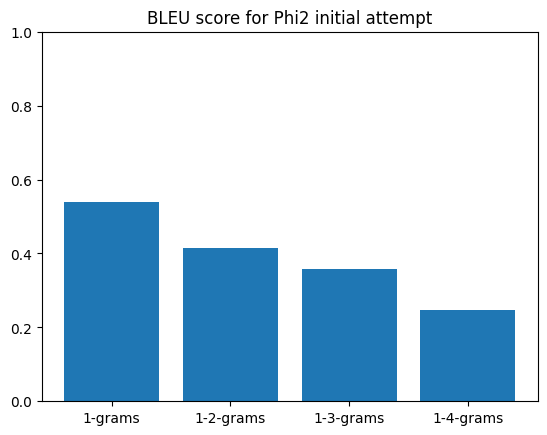

In [23]:
from nltk.translate.bleu_score import corpus_bleu,  SmoothingFunction
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
def bleu_score(csv_file):
  df_input=pd.read_csv(csv_file)
  actual, predicted=[],[]
  count=0
  for _, r in df_input.iterrows():
    #print(r["input_de"])
    #print(r["output_en"])
    #print(r["gt_en"])
    actual.append([r["en"].split()])
    predicted.append(r["predicted_en"].split())
  #print(actual)
  #print("===")
  #print(predicted)

  bleu_dic={}
  bleu_dic['1-grams']=corpus_bleu(actual, predicted, weights=(1.0,0,0,0))
  bleu_dic['1-2-grams']=corpus_bleu(actual, predicted, weights=(0.5,0.5,0,0))
  bleu_dic['1-3-grams']=corpus_bleu(actual, predicted, weights=(0.3,0.3,0.3,0))
  bleu_dic['1-4-grams']=corpus_bleu(actual, predicted, weights=(0.25,0.25,0.25,0.25))
  return bleu_dic

tinyllama_bleu=bleu_score('phi2-multi30k-v2_64.csv')

plt.bar(x=tinyllama_bleu.keys(), height=tinyllama_bleu.values())
plt.title("BLEU score for Phi2 initial attempt")
plt.ylim((0,1))
plt.show()

In [24]:
tinyllama_bleu

{'1-grams': 0.5399864834422167,
 '1-2-grams': 0.41592738369673127,
 '1-3-grams': 0.35798608734987764,
 '1-4-grams': 0.24753060117409403}

In [25]:
from nltk.translate.bleu_score import sentence_bleu

def bleu_sent_score(csv_file):
  df_input=pd.read_csv(csv_file)
  actual, predicted=[],[]
  count=0
  scores = []
  for _, r in df_input.iterrows():
    #print(r["input_de"])
    #print(r["output_en"])
    #print(r["gt_en"])
    actual.append([r["en"].split()])
    predicted.append(r["predicted_en"].split())

    score = sentence_bleu([r["en"].split()], r["predicted_en"].split())
    scores.append(score)



  return scores


tinyllama_bleu_sent=bleu_sent_score('phi2-multi30k-v2_64.csv')
import numpy as np
np.array(tinyllama_bleu_sent).mean()
    

0.1819271114653248

In [26]:
import nltk
import numpy as np
nltk.download('wordnet')
from nltk.translate.meteor_score import meteor_score
df_input = pd.read_csv('phi2-multi30k-v2_64.csv')
df_input = df_input.dropna()
actual, predicted = df_input['en'], df_input['predicted_en']
scores=[]
for reference, hypothesis in zip(actual, predicted):
    tokenized_reference = word_tokenize(reference)
    tokenized_hypothesis = word_tokenize(hypothesis)
    scores.append(meteor_score([tokenized_reference], tokenized_hypothesis))

np.array(scores).mean()

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/hamad.alhammadi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0.6140403062978518

In [28]:
from evaluate import load
comet_metric = load("comet")
predicted = df_input['predicted_en'].tolist()
actual = df_input['en'].tolist()
source = df_input['de'].tolist()
results = comet_metric.compute(predictions=predicted, references=actual, sources=source)


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to av

In [29]:
results

{'mean_score': 0.764987435311079,
 'scores': [0.9498026967048645,
  0.8798671364784241,
  0.6292179226875305,
  0.9419241547584534,
  0.9295395612716675,
  0.8089808821678162,
  0.6870957612991333,
  0.7005450129508972,
  0.9440222382545471,
  0.7516408562660217,
  0.7107166051864624,
  0.6848139762878418,
  0.6168181300163269,
  0.8909591436386108,
  0.9321147799491882,
  0.7359115481376648,
  0.7562240958213806,
  0.7457461953163147,
  0.6280759572982788,
  0.6885007619857788,
  0.9198459386825562,
  0.664332926273346,
  0.8463518023490906,
  0.6619121432304382,
  0.6265532970428467,
  0.8413498401641846,
  0.9206035137176514,
  0.7233572602272034,
  0.6761592030525208,
  0.6477177739143372,
  0.6329864859580994,
  0.5916377902030945,
  0.9385151267051697,
  0.8607612252235413,
  0.7758069038391113,
  0.7359542846679688,
  0.8775721192359924,
  0.7922716736793518,
  0.960598886013031,
  0.6310497522354126,
  0.7888849377632141,
  0.8644355535507202,
  0.8819760680198669,
  0.83316695

In [30]:
np.median(results['scores'])

0.7752321064472198

few shot

In [17]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

torch.set_default_device("cuda")

model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", torch_dtype="auto", trust_remote_code=True, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)
# Instruct chat template chat template
#inputs = tokenizer("Instruct: translate the guy with the orange hat is staring at something to german\nOutput:", return_tensors="pt", return_attention_mask=False)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [27]:
from transformers import GenerationConfig
from time import perf_counter

def generate_response2(user_input):

  #prompt = formatted_prompt(user_input)
  prompt = user_input
  inputs = tokenizer([prompt], return_tensors="pt")
  generation_config = GenerationConfig(penalty_alpha=0.6,do_sample = True,
      top_k=5,temperature=0.1,repetition_penalty=1.2,
      max_new_tokens=20,pad_token_id=tokenizer.eos_token_id
  )
  start_time = perf_counter()

  inputs = tokenizer(prompt, return_tensors="pt").to('cuda')

  outputs = model.generate(**inputs, generation_config=generation_config)
  output=tokenizer.decode(outputs[0], skip_special_tokens=True)
  #print(output)
  output_time = perf_counter() - start_time
  #print(f"Time taken for inference: {round(output_time,2)} seconds")
  return output

In [29]:
random_samples = data.shuffle(seed=42).select(range(5))
inputs = tokenizer("Instruct: translate English to German.\nInput: the guy with the orange hat is staring at something.\nOutput:", return_tensors="pt", return_attention_mask=False)
string = "Instruct: translate English to German.\n"
for sample in random_samples:
    string += f"Input: {sample['en']}\nOutput:{sample['de']}\n"


# string += "Input: the guy with the orange hat is staring at something.\nOutput:"

# #print(string)

# generate_response2(string)

# outputs = model.generate(**inputs, max_length=200)
# text = tokenizer.batch_decode(outputs)[0]
# print(text)

In [33]:
import re
mydf = pd.DataFrame(columns=['de','en','predicted_en'])
for i in tqdm(range(0,len(data_test))):
    inp = f"Input: {data_test[i]['en']}\nOutput:"
    prompt = string+inp
    out=generate_response(user_input=prompt)
    out=out.split('Output: ')[-1]
    processed_out=re.sub("[^A-Za-z0-9., ]","",out)
    mydf=pd.concat([mydf,pd.DataFrame({'de':data_test[i]['de'],'en':data_test[i]['en'],'predicted_en':processed_out},index=[0])],ignore_index=True)

100%|██████████| 1000/1000 [11:51<00:00,  1.40it/s]


In [41]:
arr = []
for i in mydf['predicted_en']:
    output = i
    if 'Instruct' in i:
        outout = i.split('Output')[-1]
    arr.append(output)



In [42]:
mydf2 = mydf.copy()

In [43]:
mydf2['predicted_en'] = arr

In [45]:
arr

['Ein Mann im Orangerie starb beim Erde zum ersten Mal.',
 'Eine Bostonerhund spielt im Wald gefroren beim weissem',
 'Eine Jugendgre im Karateuniform spielt einen St',
 'Fnf Menschen mit Winterkleider und Holzhelmgehrigen',
 'Personen arbeiten um einen Gebude zum Eiszeitraub',
 'Ein Mann im weiteren Farbe fotografieren einen Gruppe m',
 'Einen Gruppe befindlichen immer zwischen den Igloos.',
 'Ein Kind im Rotunterkleid spielt um den Stadionplatz',
 'Einen Mann arbeitete beim Bauten.',
 'Ein Mann im Vest spielt im Teppich und hrt Magazins.',
 'Eine Mutter und ihre junge Sohn singen am heutigsten Tag',
 'Instruct Translate German to English.Input Instruct translate English to German.Input A lady wearing green and white shorts and top is on the beach clapping her hands.OutputEine Dame mit grnweien Shorts und Oberteil ist auf dem Strand und klatscht in die Hnde.Input A couple takes their own picture in front of the Arc De TRiomphe, from across the street.OutputEin Paar macht auf der ander